<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Keep part in this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [7]:
import pandas as pd

shops = pd.read_csv('./data/yelp_coffeeshop_review_data.csv')
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [5]:
# Base
from collections import Counter
import re

import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_md")

In [6]:
nlp

In [14]:
import re

re.sub(r'[^a-zA-Z ]', '', shops['full_review_text'].iloc[1])

'  Listed in Date Night Austin Ambiance in Austin BEAUTIFUL Love the ambiance Instagramworthy  Definitely  so be prepared This is gonna cost you a pretty penny  Waffle dessert was just decentnothing to rave about  But will probably be back just to be somewhere unique and nice '

In [19]:
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub(r'[^a-zA-Z ]', '', text)
    tokens = tokens.lower().split()
    
    return tokens

In [20]:
shops['full_review_text'].iloc[1]

' 12/2/2016 Listed in Date Night: Austin, Ambiance in Austin BEAUTIFUL!!!! Love the ambiance! Instagram-worthy!!!  Definitely $$$, so be prepared. This is gonna cost you a pretty penny :) Waffle dessert was just decent...nothing to rave about.  But, will probably be back just to be somewhere unique and nice. '

In [21]:
shops['tokens'] = shops['full_review_text'].apply(tokenize)

In [22]:
shops

,coffee_shop_name,full_review_text,star_rating,tokens
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,"[checkin, love, love, loved, the, atmosphere, ..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"[listed, in, date, night, austin, ambiance, in..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,"[checkin, listed, in, brunch, spots, i, loved,..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,"[very, cool, decor, good, drinks, nice, seatin..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,"[checkin, they, are, located, within, the, nor..."
5,The Factory - Cafe With a Soul,11/20/2016 1 check-in Very cute cafe! I think...,4.0 star rating,"[checkin, very, cute, cafe, i, think, from, th..."
6,The Factory - Cafe With a Soul,"10/27/2016 2 check-ins Listed in ""Nuptial Cof...",4.0 star rating,"[checkins, listed, in, nuptial, coffee, bliss,..."
7,The Factory - Cafe With a Soul,11/2/2016 2 check-ins Love this place! 5 sta...,5.0 star rating,"[checkins, love, this, place, stars, for, clea..."
8,The Factory - Cafe With a Soul,"10/25/2016 1 check-in Ok, let's try this appr...",3.0 star rating,"[checkin, ok, lets, try, this, approach, pros,..."
9,The Factory - Cafe With a Soul,11/10/2016 3 check-ins This place has been sh...,5.0 star rating,"[checkins, this, place, has, been, shown, on, ..."


df['tokens'] = shops['full_review_text'].apply(tokenize)

In [27]:
# Object from Base Python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

# Update it based on a split of each of our documents
shops['tokens'].apply(lambda x: word_counts.update(x))

# Print out the 10 most common words
word_counts.most_common(10)

[('the', 34809),
 ('and', 26651),
 ('a', 22756),
 ('i', 20249),
 ('to', 17164),
 ('of', 12600),
 ('is', 11999),
 ('coffee', 10354),
 ('was', 9707),
 ('in', 9546)]

In [47]:
Counter(['one two','two','two','four'])

Counter({'one two': 1, 'two': 2, 'four': 1})

In [44]:
set(zip(Counter(['one two','two','two','four']).values(), Counter(['one two','two','two','four']).keys()))

{(1, 'four'), (1, 'one two'), (2, 'two')}

In [48]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [50]:
wc = count(shops['tokens'])

In [51]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
46,the,6847,34809,1.0,0.045412,0.045412,0.899028
12,and,6864,26651,2.0,0.034769,0.080180,0.901261
57,a,6246,22756,3.0,0.029687,0.109868,0.820116
61,i,5532,20249,4.0,0.026417,0.136284,0.726366
42,to,5653,17164,5.0,0.022392,0.158676,0.742253


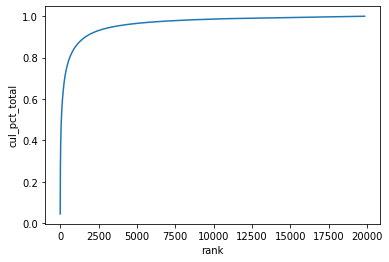

In [52]:
import seaborn as sns

# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [55]:
wc[wc['rank'] <= 4750]['cul_pct_total'].max()

0.9635966565908631

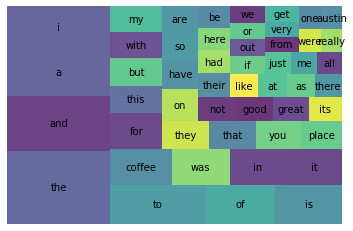

In [59]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 50]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [60]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_md")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [ ]:
[token.text for token in tokenizer(sample)]

In [80]:
# Tokenizer Pipe

tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc[1:]]
    tokens.append(doc_tokens)

shops['tokens2'] = tokens

In [81]:
shops['tokens2']

0       [11/25/2016, 1, check-in, Love, love, loved, t...
1       [12/2/2016, Listed, in, Date, Night:, Austin,,...
2       [11/30/2016, 1, check-in, Listed, in, Brunch, ...
3       [11/25/2016, Very, cool, decor!, Good, drinks,...
4       [12/3/2016, 1, check-in, They, are, located, w...
5       [11/20/2016, 1, check-in, Very, cute, cafe!, I...
6       [10/27/2016, 2, check-ins, Listed, in, "Nuptia...
7       [11/2/2016, 2, check-ins, Love, this, place!, ...
8       [10/25/2016, 1, check-in, Ok,, let's, try, thi...
9       [11/10/2016, 3, check-ins, This, place, has, b...
10      [10/22/2016, 1, check-in, Listed, in, American...
11      [11/20/2016, The, store, has, A+, decoration,,...
12      [11/17/2016, 1, check-in, Listed, in, 2016, -,...
13      [12/5/2016, This, is, such, a, cute, little, c...
14      [11/13/2016, Beautiful, eccentric, coffee, sho...
15      [11/9/2016, 1, check-in, Listed, in, In, Searc...
16      [11/6/2016, Really, love, the, atmosphere, her...
17      [10/25

In [82]:
print(tokenizer.pipe(shops['full_review_text'], batch_size=500))

In [83]:
wc = count(shops['tokens2'])

In [84]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
50,the,6520,27779,1.0,0.034660,0.034660,0.856092
2,and,6804,25748,2.0,0.032126,0.066786,0.893382
69,a,6181,22085,3.0,0.027556,0.094342,0.811581
35,I,5469,19780,4.0,0.024680,0.119021,0.718093
67,to,5631,16904,5.0,0.021091,0.140112,0.739364


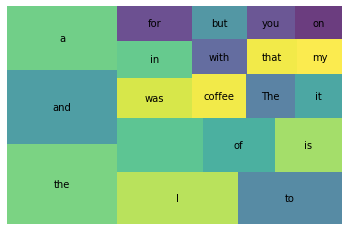

In [93]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [ ]:
nlp.Defaults.stop_words

In [109]:
STOP_WORDS = nlp.Defaults.stop_words.union([' ','I', 'i', 'and', 'it', "it's", 'it.', 'the', 'this','of', 'is', 'my', 'but'])

In [110]:
# Tokenizer Pipe

tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = []
    for token in doc[1:]:
        if token.text not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)
        
            
shops['tokens2'] = tokens

In [111]:
doc_tokens

['5/23/2015',
 'finally',
 'stopped',
 'lunch',
 'colleague',
 "i'm",
 'glad',
 'did.',
 'delicious',
 'coconut',
 'milk',
 'soup',
 'chai',
 'tea.',
 'yum!']

In [ ]:
tokens

In [105]:
shops['tokens2']

0       [11/25/2016, 1, check-in, love, love, loved, a...
1       [12/2/2016, listed, date, night:, austin,, amb...
2       [11/30/2016, 1, check-in, listed, brunch, spot...
3       [11/25/2016, very, cool, decor!, good, drinks,...
4       [12/3/2016, 1, check-in, they, located, northc...
5       [11/20/2016, 1, check-in, very, cute, cafe!, t...
6       [10/27/2016, 2, check-ins, listed, "nuptial, c...
7       [11/2/2016, 2, check-ins, love, place!,  , 5, ...
8       [10/25/2016, 1, check-in, ok,, let's, try, app...
9       [11/10/2016, 3, check-ins, this, place, shown,...
10      [10/22/2016, 1, check-in, listed, americano, t...
11      [11/20/2016, the, store, a+, decoration,, hone...
12      [11/17/2016, 1, check-in, listed, 2016, -, the...
13      [12/5/2016, this, cute, little, cafe!, i've, d...
14      [11/13/2016, beautiful, eccentric, coffee, sho...
15      [11/9/2016, 1, check-in, listed, in, search, f...
16      [11/6/2016, really, love, atmosphere, here!, f...
17      [10/25

In [113]:
wc = count(shops['tokens2'])

In [114]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
38,coffee,4210,8058,1.0,0.018720,0.018720,0.552784
148,the,3936,6870,2.0,0.015960,0.034680,0.516807
130,place,3029,4264,3.0,0.009906,0.044586,0.397715
99,great,2438,3250,4.0,0.007550,0.052136,0.320116
188,like,2034,2902,5.0,0.006742,0.058878,0.267069


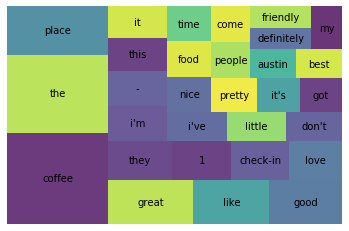

In [117]:
wc_top30 = wc[wc['rank'] <= 30]

squarify.plot(sizes=wc_top30['pct_total'], label=wc_top30['word'], alpha=0.8)
plt.axis('off')
plt.show()



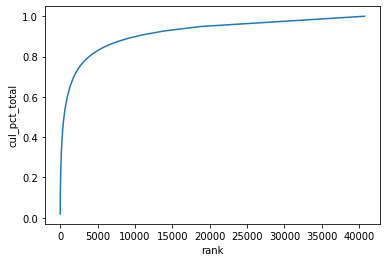

In [118]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc);


In [119]:
wc['appears_in_pct'].describe()


count    40726.000000
mean         0.001246
std          0.007973
min          0.000131
25%          0.000131
50%          0.000131
75%          0.000525
max          0.552784
Name: appears_in_pct, dtype: float64

C:\Users\mhdal\Anaconda3\envs\lambda-nlp\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


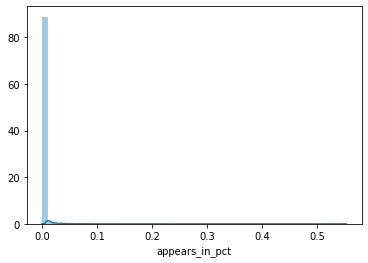

In [120]:
sns.distplot(wc['appears_in_pct']);

In [121]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()


In [136]:
range(len(shops))

range(0, 7616)

In [ ]:
stems = []

""" Make them tokens """
for i in range(len(shops)):
        for word in shops['tokens2'].iloc[i,]:
            shops['stems'] = ps.stem(word)
shops['stems']


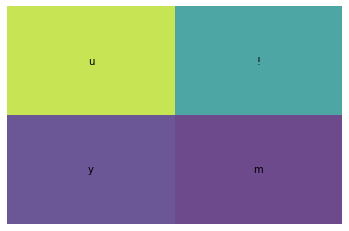

In [134]:
wc = count(shops['stems'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [137]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [138]:
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)


In [139]:
shops['lemmas'].head()

0    [ , 11/25/2016, 1, check, in, love, love, love...
1    [ , 12/2/2016, listed, in, date, night, austin...
2    [ , 11/30/2016, 1, check, in, listed, in, brun...
3    [ , 11/25/2016, very, cool, decor, good, drink...
4    [ , 12/3/2016, 1, check, in, be, locate, withi...
Name: lemmas, dtype: object

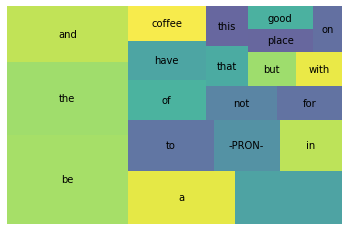

In [140]:
wc = count(shops['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()